# Assignment 5: Classification Showdown

Build and compare classification models on the Fashion-MNIST dataset.

## Setup

In [2]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from xgboost import XGBClassifier

from helpers import load_fashion_mnist, plot_roc_curves, plot_confusion_matrix

# Create output directory
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete!")

Setup complete!


---

## Part 1: Binary Classification

**Task:** Classify T-shirts (label 0) vs Trousers (label 1)

This is a straightforward binary classification task. Focus on:
- Filtering data to the target classes
- Proper train/test splitting with stratification
- Scaling features correctly (fit on train only!)

In [3]:
print("Part 1: Binary Classification")
print("-" * 40)

# Load the full dataset
X, y = load_fashion_mnist()

# Filter to only labels 0 and 1
# Hint: np.isin(y, [0, 1]) returns a boolean array where True means the label is 0 or 1
# Use this mask to index into X and y: X[mask], y[mask]
mask = np.isin(y, [0, 1])  # TODO: create boolean mask for labels 0 and 1
X_filtered = X[mask]  # TODO: apply mask to X
y_filtered = y[mask]  # TODO: apply mask to y

# Train/test split with stratification
# Use test_size=0.2, random_state=42, stratify=y_filtered
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)  # TODO

# Scale features - fit on train, transform both
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # TODO: fit_transform on X_train
X_test_scaled = scaler.transform(X_test)  # TODO: transform X_test (not fit_transform!)

# Train LogisticRegression (use max_iter=1000, random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)  # TODO
model.fit(X_train_scaled, y_train)  # TODO: fit the model

# Evaluate
y_pred = model.predict(X_test_scaled)  # TODO: predict on X_test_scaled
accuracy = accuracy_score(y_test, y_pred)  # TODO: calculate accuracy_score
cm = confusion_matrix(y_test, y_pred)  # TODO: calculate confusion_matrix

# Save results
results = {
    "task": "tshirt_vs_trouser",
    "accuracy": accuracy,
    "confusion_matrix": cm.tolist(),  # Convert numpy array to list for JSON
}
with open(os.path.join(OUTPUT_DIR, "part1_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{cm}")

Part 1: Binary Classification
----------------------------------------
Accuracy: 0.9836
Confusion Matrix:
[[1371   29]
 [  17 1383]]


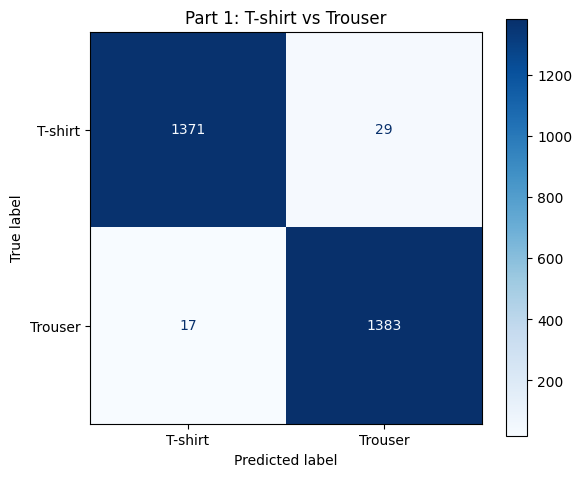

In [4]:
# Visualize results (provided - not part of assignment)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["T-shirt", "Trouser"]).plot(
    ax=ax, cmap="Blues"
)
ax.set_title("Part 1: T-shirt vs Trouser")
plt.tight_layout()
plt.show()

---

## Part 2: Multi-class Classification with Cross-Validation

**Task:** Classify footwear types: Sandal (5) vs Sneaker (7) vs Ankle boot (9)

Compare three models using 5-fold cross-validation. Select the best model and evaluate on test set.

**Required outputs:**
- `output/part2_cv_results.csv` - columns: `model`, `fold`, `score`
- `output/part2_test_results.csv` - classification report as DataFrame

In [ ]:
print("\nPart 2: Multi-class Classification with CV")
print("-" * 40)

# TODO: Load data, filter to labels 5, 7, 9
X, y = load_fashion_mnist()
mask = np.isin(y, [5, 7, 9])
X_filtered = X[mask]
y_filtered = y[mask]

# TODO: Encode labels to 0, 1, 2 using LabelEncoder (required for XGBoost)
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)  # [5,7,9] -> [0,1,2]

# TODO: Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# TODO: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to compare
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=100, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1),
}

# TODO: Run 5-fold CV for each model (use StratifiedKFold, scoring='accuracy')
# TODO: Save CV results to part2_cv_results.csv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_rows = []
for name, model in models.items():
    # Scale for LR/XGBoost; keep raw for RandomForest
    X_cv = X_train_scaled if name in ["LogisticRegression", "XGBoost"] else X_train

    scores = cross_val_score(model, X_cv, y_train, cv=cv, scoring="accuracy", n_jobs=-1)

    cv_rows.append(
        {
            "model": name,
            "mean_cv_accuracy": float(scores.mean()),
            "std_cv_accuracy": float(scores.std()),
            "fold1": float(scores[0]),
            "fold2": float(scores[1]),
            "fold3": float(scores[2]),
            "fold4": float(scores[3]),
            "fold5": float(scores[4]),
        }
    )

cv_df = pd.DataFrame(cv_rows).sort_values("mean_cv_accuracy", ascending=False)

cv_path = os.path.join(OUTPUT_DIR, "part2_cv_results.csv")
cv_df.to_csv(cv_path, index=False)
print(f"Saved CV results -> {cv_path}")
print(cv_df)

# Convert CV results to long format for plotting (required by the provided plot cell)
fold_cols = [c for c in cv_df.columns if c.startswith("fold")]

cv_df = cv_df.melt(
    id_vars=["model"], value_vars=fold_cols, var_name="fold", value_name="score"
)


Part 2: Multi-class Classification with CV
----------------------------------------
Saved CV results -> output/part2_cv_results.csv
                model  mean_cv_accuracy  std_cv_accuracy     fold1     fold2  \
2             XGBoost          0.967024         0.003289  0.964881  0.964583   
1        RandomForest          0.952202         0.003758  0.948810  0.949405   
0  LogisticRegression          0.927321         0.006238  0.930655  0.931250   

      fold3     fold4     fold5  
2  0.963690  0.970238  0.971726  
1  0.950893  0.952679  0.959226  
0  0.915774  0.925893  0.933036  


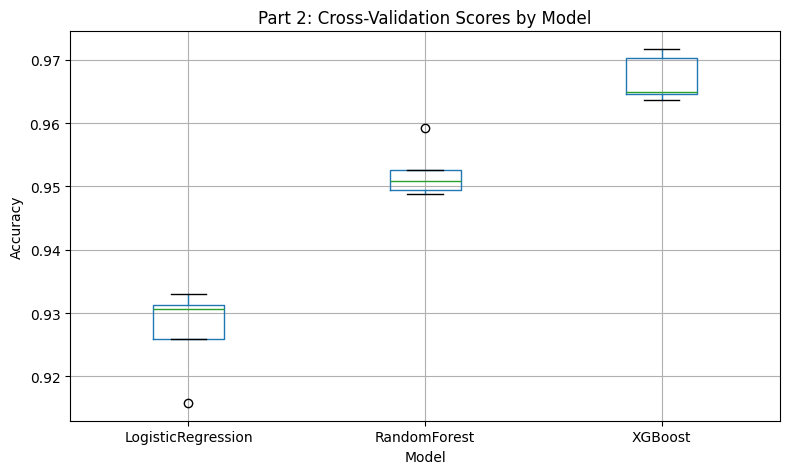

In [15]:
# Visualize CV results (provided - not part of assignment)
import matplotlib.pyplot as plt

try:
    fig, ax = plt.subplots(figsize=(8, 5))
    cv_df.boxplot(column="score", by="model", ax=ax)
    ax.set_title("Part 2: Cross-Validation Scores by Model")
    ax.set_xlabel("Model")
    ax.set_ylabel("Accuracy")
    plt.suptitle("")  # Remove automatic title
    plt.tight_layout()
    plt.show()
except NameError:
    print("cv_df not defined yet - complete the TODOs above first!")

---

## Part 3: Full Model Comparison Pipeline

**Task:** Classify Clothing vs Footwear (binary)

- **Clothing (0):** T-shirt, Trouser, Pullover, Dress, Coat, Shirt (labels 0-4, 6)
- **Footwear (1):** Sandal, Sneaker, Ankle boot (labels 5, 7, 9)
- **Exclude:** Bag (label 8)

Compare 3 models using AUC, generate ROC curves, evaluate best model.

**Required outputs:**
- `output/part3_cv_results.csv` - columns: `model`, `fold`, `auc`
- `output/part3_test_results.csv` - columns: `model`, `accuracy`, `auc`
- `output/part3_roc_curves.png` - use `plot_roc_curves()` from helpers
- `output/part3_confusion_matrix.png` - use `plot_confusion_matrix()` from helpers

In [ ]:
print("\nPart 3: Full Model Comparison Pipeline")
print("-" * 40)

# TODO: Load data, filter out bags (label 8)
# TODO: Create binary labels: footwear (5, 7, 9) = 1, clothing = 0
# TODO: Train/test split with stratification
# TODO: Scale features

# Models to compare
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=100, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1),
}

# TODO: Run 5-fold CV for all models (use StratifiedKFold, scoring='roc_auc')
# TODO: Save CV results to part3_cv_results.csv
# TODO: Find best model by mean AUC
# TODO: Train ALL models on full training data (needed for ROC curves)
# TODO: Generate ROC curves: plot_roc_curves(trained_models, X_test_scaled, y_test, save_path)
# TODO: Evaluate best model on test set (accuracy and AUC)
# TODO: Generate confusion matrix: plot_confusion_matrix(y_test, y_pred, ['Clothing', 'Footwear'], save_path)
# TODO: Save test results to part3_test_results.csv

---

## Validation

In [ ]:
# Run in terminal: pytest .github/tests/ -v
print("Run 'pytest .github/tests/ -v' in your terminal to check your work.")